In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import convolve

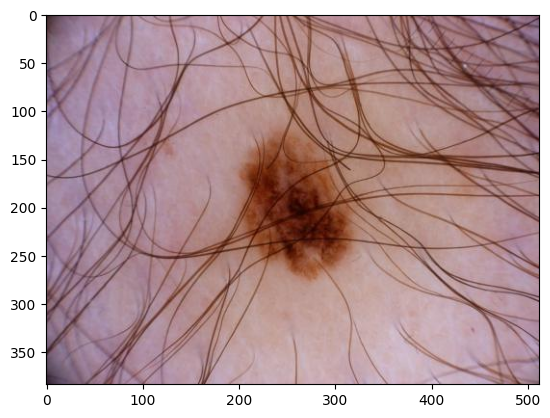

In [3]:
img = cv2.cvtColor(cv2.imread('./Train/Train/ISIC_0000095.jpg'),cv2.COLOR_BGR2RGB)
plt.imshow(img)

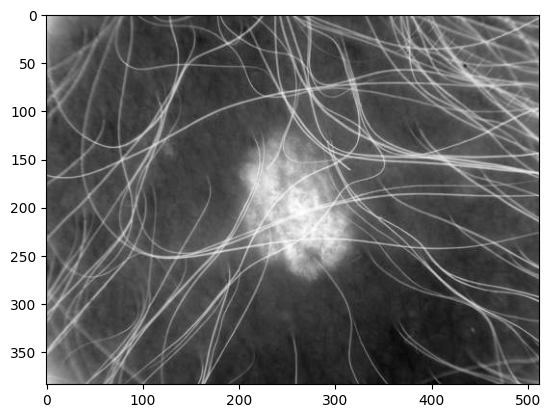

In [4]:
img = img.reshape(-1,3)
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(img)
best_contrast = pca.transform(img).reshape(384,512)

plt.imshow(best_contrast,cmap='gray')

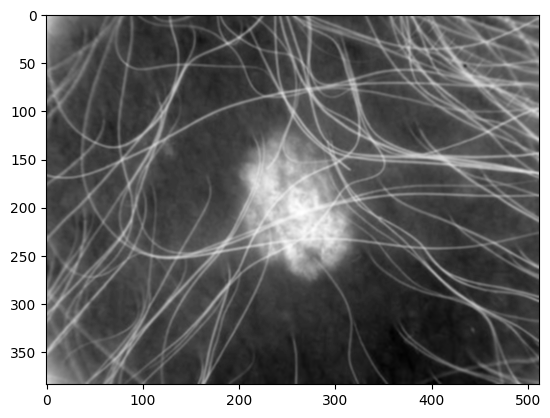

In [5]:
def gaussian_kernel(size, sigma=1):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        return g

g = gaussian_kernel(3)

im_blur = convolve(best_contrast,g)
plt.imshow(im_blur,cmap='gray')

In [6]:
def sobel_filters(img):
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

        Ix = convolve(img, Kx)
        Iy = convolve(img, Ky)

        G = np.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
        return (G, theta)

In [7]:
grad, thet = sobel_filters(im_blur)

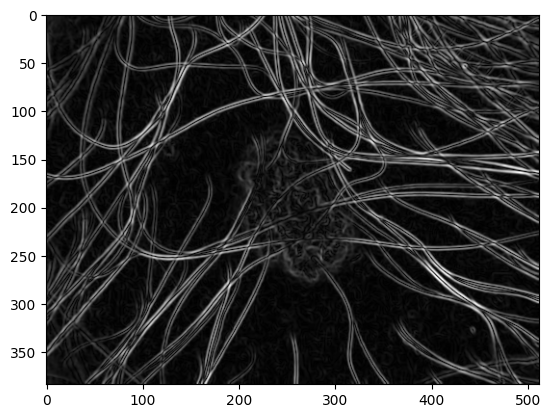

In [8]:
plt.imshow(grad,cmap='gray')

In [9]:
def non_max_suppression(img, D):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180


        for i in range(1,M-1):
            for j in range(1,N-1):
                try:
                    q = 255
                    r = 255

                   #angle 0
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = img[i, j+1]
                        r = img[i, j-1]
                    #angle 45
                    elif (22.5 <= angle[i,j] < 67.5):
                        q = img[i+1, j-1]
                        r = img[i-1, j+1]
                    #angle 90
                    elif (67.5 <= angle[i,j] < 112.5):
                        q = img[i+1, j]
                        r = img[i-1, j]
                    #angle 135
                    elif (112.5 <= angle[i,j] < 157.5):
                        q = img[i-1, j-1]
                        r = img[i+1, j+1]

                    if (img[i,j] >= q) and (img[i,j] >= r):
                        Z[i,j] = img[i,j]
                    else:
                        Z[i,j] = 0


                except IndexError as e:
                    pass

        return Z

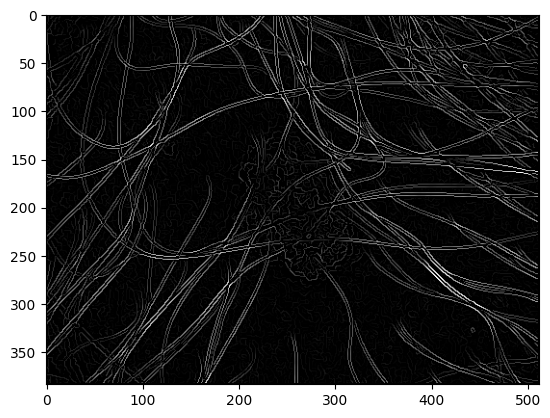

In [10]:
nonMaxImg = non_max_suppression(grad,thet)
plt.imshow(nonMaxImg,cmap='gray')

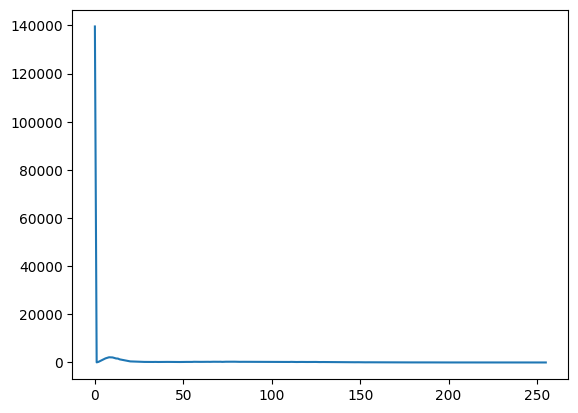

In [11]:
n = np.max(nonMaxImg)
h,bins = np.histogram(nonMaxImg,bins=n+1)
plt.plot(np.linspace(0,n,n+1),h)

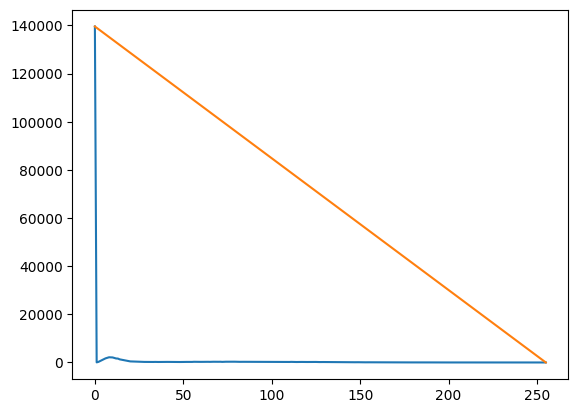

In [12]:
#Get convex hull of histogram an maximum concavity
hull = np.zeros(n+1)
k=0
hk=h[k]
npr = h.shape[0]
while k < npr-1 :
    tmax = np.NINF
    new_k = 0
    for i in range(k+1,npr):
        t = (h[i]-hk)/(i-k)
        if t >= tmax:
            tmax = t
            new_k = i
    hull[k:new_k] = np.linspace(k,new_k-1,new_k-k)*tmax+hk
    k = new_k
    hk = h[k]

plt.plot(np.linspace(0,n,n+1),h)
plt.plot(np.linspace(0,n,n+1),hull)
    


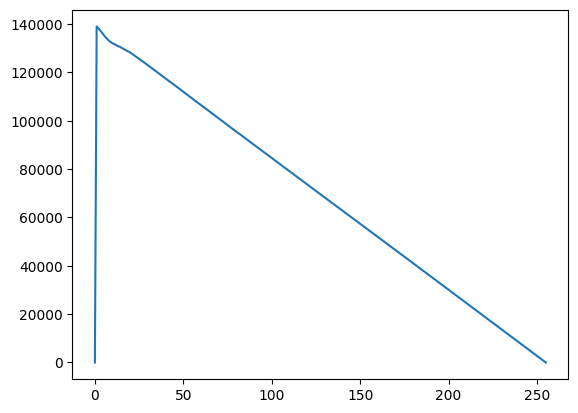

In [13]:
concavities = hull-h
plt.plot(np.linspace(0,n,n+1),concavities)

In [14]:
threshold = np.argmax(concavities)
print(threshold)

1


In [20]:
threshold = 20

In [21]:
def thresholding(img):

        highThreshold = threshold
        lowThreshold = threshold * 0.4

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)


        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)

        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = 2
        res[weak_i, weak_j] = 1

        return (res)

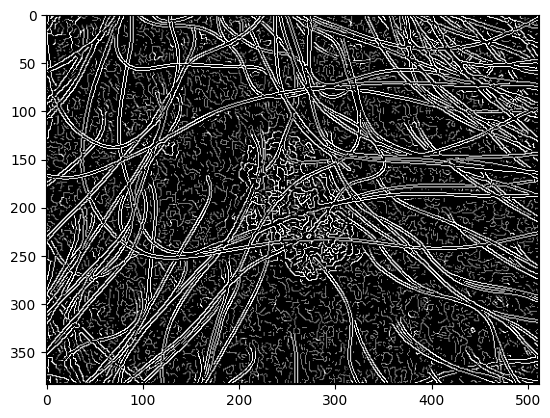

In [22]:
stre = thresholding(nonMaxImg)
plt.imshow(stre,cmap='gray')

In [23]:
def hysteresis(img):

        M, N = img.shape
        weak = 1
        strong = 2

        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    try:
                        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError as e:
                        pass

        return img

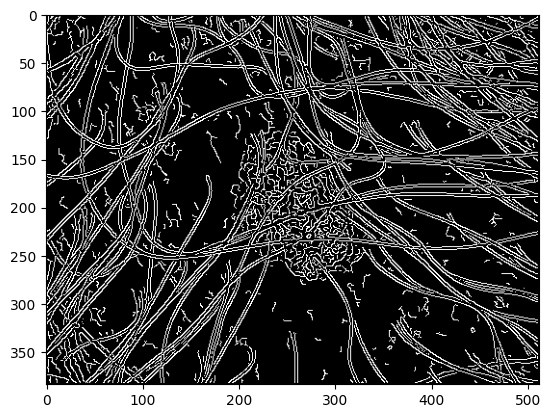

In [24]:
histim = hysteresis(stre)
plt.imshow(histim,cmap='gray')